## Complementarity & Accessibilty

### 1.  Imports & Declarations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from sklearn.cluster import DBSCAN
# from haversine import haversine as hs
import requests
%matplotlib inline
# from pydantic_settings import BaseSettings
#from ydata_profiling import ProfileReport

import sys
import os
sys.path.append('../utils/')
#sys.path.append('..\\utils\\')

from functions import get_zone_info
from functions import haversine_distance as hsd
from functions import main_concurrent

In [2]:
##############################################################################################################
# GREEN MOBILITY
##############################################################################################################

# Initialize dataframe
file_path = "../data/processed/gm_raw.csv"
gm_source = pd.read_csv(file_path)

# Rename columns if necessary

# Drop columns if necessary

# Descriptive statistics

# Drop outliers, missing values, etc.

# Add columns if necessary

#################################################################################################################
# DRIVE NOW
#################################################################################################################

# 1. Initialize dataframe
file_path = "../data/raw/DriveNow/DTU - data til case_LTMZones1.csv"
sn_source = pd.read_csv(file_path, sep=";")

# 2. Rename columns if necessary
sn_source.rename(columns= {
                            "Latitude (Start)": "LatitudeStart", 
                            "Longitude (Start)": "LongitudeStart", 
                            'Latitude (Slut)': "LatitudeEnd", 
                            'Longitude (Slut)':'LongitudeEnd',
                            'Reservationstidspunkt': "ReservationTime",
                            'Start tidspunkt': "StartTime",
                            'Slut tidspunkt': "EndTime",
                            'Alder': "Age",
                            'Køn': "Gender",
                            'Batteristatus (start)': "BatteryStart",
                            'Batteristatus (slut)':"BatteryEnd",
                            'Km kørt': "KmDriven"
                            }, inplace=True)

# 3. Drop columns if necessary
sn_source.drop(columns=['TurID'],inplace=True)

# 4. Convert to appropriate data types
# Convert to Numeric the following columns:
coordinates = [
    'LatitudeEnd',
    'LatitudeStart',
    'LongitudeEnd',
    'LongitudeStart'
]

for col in coordinates:
    sn_source[col] = sn_source[col].apply(lambda x: x.replace(',','.'))
    sn_source[col] = pd.to_numeric(sn_source[col],errors='coerce')

target_ls = [
    'KmDriven',
    'BatteryStart',
    'BatteryEnd',
]
for col in target_ls:
    sn_source[col] = pd.to_numeric(sn_source[col],errors='coerce')

sn_source['EndTime'] = pd.to_datetime(sn_source['EndTime'], errors='coerce')    #   to DateTime
sn_source['StartTime'] = pd.to_datetime(sn_source['StartTime'], errors='coerce')    #   to Datetime


# 5. Auxiliary columns
sn_source['TripDurationHours'] = (sn_source['EndTime'] - sn_source['StartTime']).dt.total_seconds()/3600
sn_source['TripDurationMinutes'] = sn_source['TripDurationHours']*60  #   trip duration in min
sn_source['AvgSpeed'] = sn_source['KmDriven']/sn_source['TripDurationHours'] #   avg speed

sn_source['Month'] = sn_source['StartTime'].dt.strftime("%B").astype('category')  #   month
sn_source['Weekday'] = sn_source['StartTime'].dt.day_name().astype('category')    #   day of the week
sn_source['StartHour'] = sn_source['StartTime'].dt.hour.astype('category')    #   hour of the day

# 6. Descriptive statistics
sn_source.describe()

# 7. Drop outliers, missing values, etc.

# drop rows with missing values
sn_source.dropna(inplace=True)

# drop rows with BatteryEnd more than BatteryStart
sn_source = sn_source[sn_source['BatteryStart'] >= sn_source['BatteryEnd']]

# drop rows with coordinates equal to 0 
for col in coordinates:
    sn_source = sn_source[(sn_source[col] != 0)|(sn_source[col] != '')]


# replace negative BatteryEnd with 0
sn_source['BatteryEnd'] = sn_source['BatteryEnd'].apply(lambda x: 0 if x < 0 else x)

# # drop rows with negative and avg speed > 100 km/h
sn_source = sn_source[(sn_source['AvgSpeed'] > 1) & (sn_source['AvgSpeed'] < 100)]


# # 8. Add columns if necessary
# # Add haversise distance to the dataframe
sn_source['HaversineDistance'] = hsd(sn_source['LatitudeStart'], sn_source['LongitudeStart'],sn_source['LatitudeEnd'], sn_source['LongitudeEnd'])
# sn_source['HaversineDistance'] = sn_source['HaversineDistance'].apply(lambda x: round(x,0))

# # drop rows with Haversine distance > 1000 km
sn_source = sn_source[sn_source['HaversineDistance'] < 1000]

##################################################################################################################
# DONKEY REPUBLIC
##################################################################################################################


# Initialize Donkey Republic dataframe
# file_path = ""
# donkey_source = ""

# Rename columns if necessary

# Drop columns if necessary

# Descriptive statistics

# Drop outliers, missing values, etc.



/var/folders/77/lfxftc1s7_bch_43_w38l1zh0000gn/T/ipykernel_83063/1770929939.py:25: DtypeWarning: Columns (12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  sn_source = pd.read_csv(file_path, sep=";")
/var/folders/77/lfxftc1s7_bch_43_w38l1zh0000gn/T/ipykernel_83063/1770929939.py:67: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  sn_source['EndTime'] = pd.to_datetime(sn_source['EndTime'], errors='coerce')    #   to DateTime
/var/folders/77/lfxftc1s7_bch_43_w38l1zh0000gn/T/ipykernel_83063/1770929939.py:68: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  sn_source['StartTime'] = pd.to_datetime(sn_source['StartTime'], errors='coerce')    #   to Datetime


## Visualizations

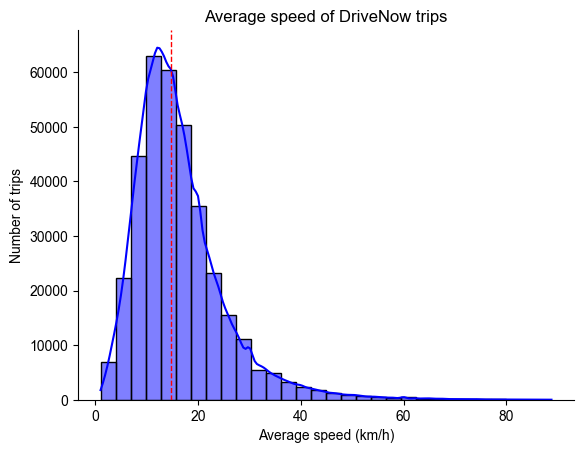

In [3]:
# plot histogram of average speed between 0 and 90 km/h using seaborn 
sns.histplot(data=sn_source[(sn_source['AvgSpeed']>0) & (sn_source['AvgSpeed']<90)], x="AvgSpeed", bins=30, color='blue', kde=True)
# change color of histogram
sns.set_palette('Blues_r')
sns.set_style('whitegrid')

sns.despine()

# add title and labels
plt.title("Average speed of DriveNow trips")
plt.xlabel("Average speed (km/h)")
plt.ylabel("Number of trips")
plt.grid(False)
# plt.show()

# show median on the plot
plt.axvline(x=sn_source['AvgSpeed'].median(), color='red', linestyle='--', linewidth=1)
plt.show()

#### 2.1 Short Trips ShareNow: Clustering and Analysis

In [4]:
# Define short trips :: trips with distance between 5 and 40 km
sn_shorttrips = sn_source[(sn_source['KmDriven'] < 40)&(sn_source['KmDriven']>=3)]

# print the percentage of short trips using f string

print(f'{sn_shorttrips.shape[0]/sn_source.shape[0]}')

0.8723156434718756


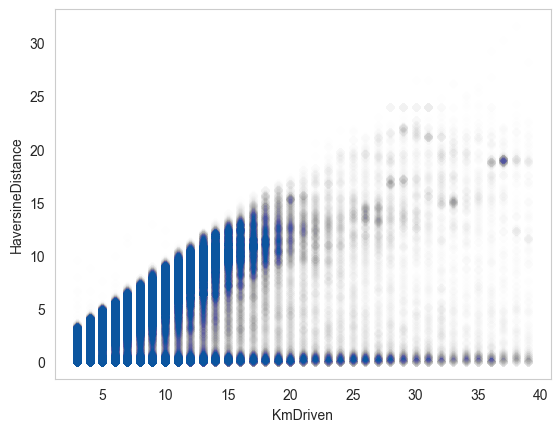

In [5]:
sns.scatterplot(data=sn_shorttrips, x="KmDriven", y="HaversineDistance", alpha=0.005)
# change color of histogram
sns.set_palette('Blues_r')
sns.set_style('whitegrid')
plt.grid(False)
plt.show()

### ShareNow Short Trips :: Clusters on scatter plot

#### Estimate the values for $\epsilon$ and Minimum samples

In [46]:
# export to csv sn_shorttrips
sn_shorttrips.to_csv('../data/processed/sn_shorttrips.csv', index=False)

In [43]:
# run DBSCAN clustering algorithm on KmDriven and HaversineDistance

db = DBSCAN(eps=0.47, min_samples=6000, n_jobs=-1).fit(sn_shorttrips[['KmDriven','HaversineDistance']])

# add the cluster labels to the dataframe
sn_shorttrips['Cluster'] = db.labels_

/var/folders/77/lfxftc1s7_bch_43_w38l1zh0000gn/T/ipykernel_83063/1931237923.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sn_shorttrips['Cluster'] = db.labels_


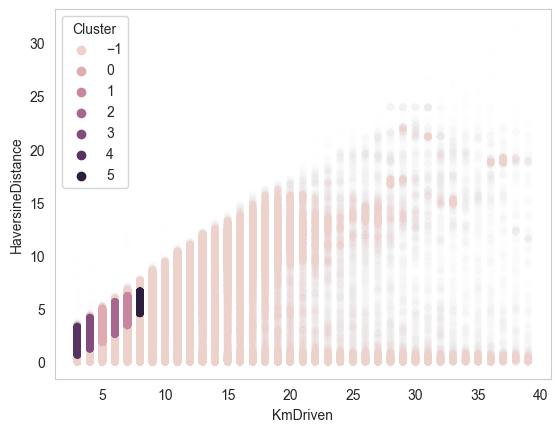

In [44]:
sns.scatterplot(data=sn_shorttrips, x="KmDriven", y="HaversineDistance", hue='Cluster',alpha=0.005)
# change color of histogram
# sns.set_palette('Blues_r')
sns.set_style('whitegrid')
plt.grid(False)
plt.show()

In [45]:
sn_shorttrips[sn_shorttrips['Cluster']>-1].shape[0]/sn_shorttrips.shape[0]*100
# sn_shorttrips['Cluster'].value_counts()

58.768928093402785

In [ ]:
# plot 4 figures in 2 rows and 2 columns
fig, ax = plt.subplots(2,2, figsize=(15,10))


## STATISTICAL ANALYSIS : Hypothesis testing

In [47]:
sn_full = pd.read_csv('../data/processed/sn_shtrips_access_complete.csv')

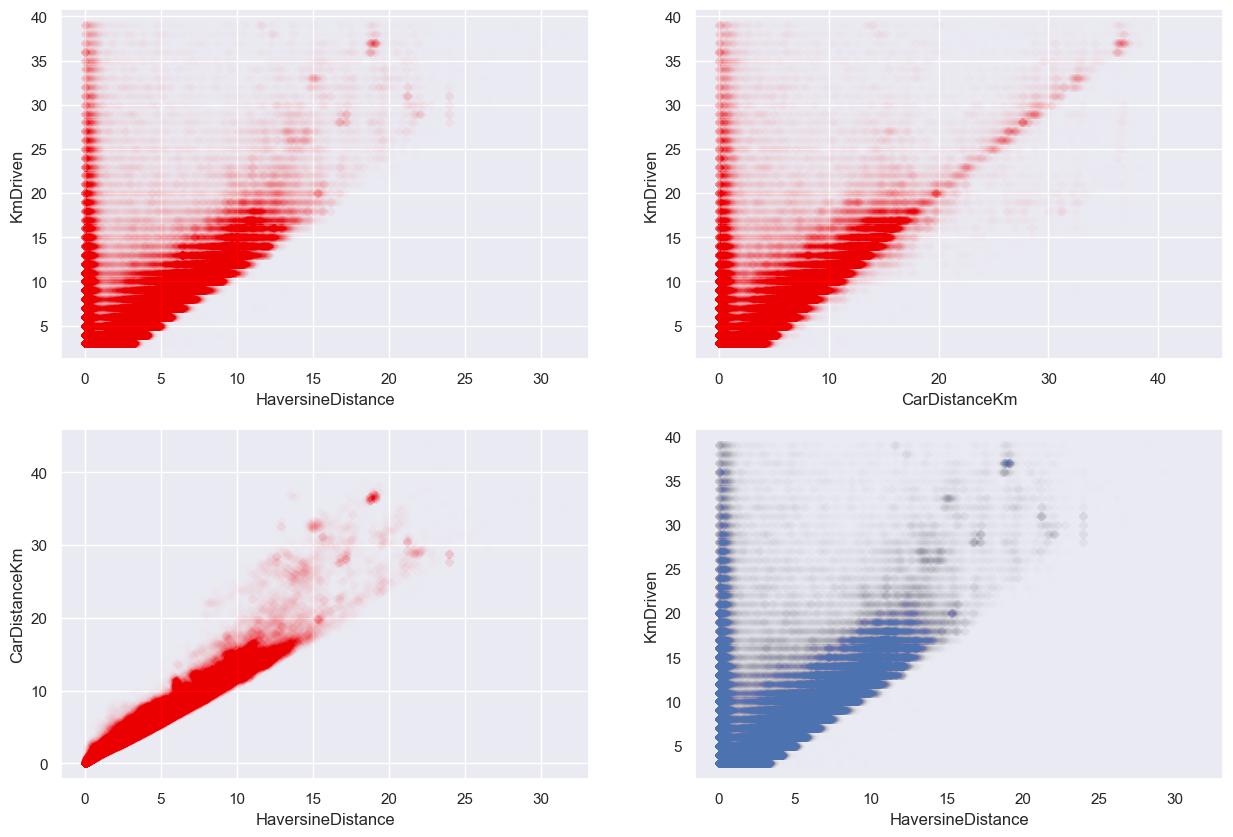

In [48]:
sns.set()
fig, axes = plt.subplots(2,2, figsize = (15,10))
sns.scatterplot(ax = axes[0][0],data=sn_full,x='HaversineDistance',y='KmDriven',alpha=0.005,color='red')
sns.scatterplot(ax = axes[0][1],data=sn_full,x='CarDistanceKm',y='KmDriven',alpha=0.005,color='red')
sns.scatterplot(ax = axes[1][0],data=sn_full,x='HaversineDistance',y='CarDistanceKm',alpha=0.005,color='red')
sns.scatterplot(ax = axes[1][1],data=sn_shorttrips,x='HaversineDistance',y='KmDriven',alpha=0.005)
sns.set_style('whitegrid')
plt.grid(False)
plt.show()

In [49]:
sn_full['DrivenStraightRatio'] = sn_full['KmDriven']/sn_full['HaversineDistance']
sn_full['OptimumRatio'] = sn_full['KmDriven']/sn_full['CarDistanceKm']

In [71]:
# categorize the Optimum Ratio in 10 categories
# sn_full['OptimumRatioCat'] = pd.cut(sn_full['OptimumRatio'], bins=10, labels=False)

newbins = [0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5]
sn_full['OptimumRatioCat'] = pd.cut(sn_full['OptimumRatio'], bins=newbins, labels=newbins[:-1])

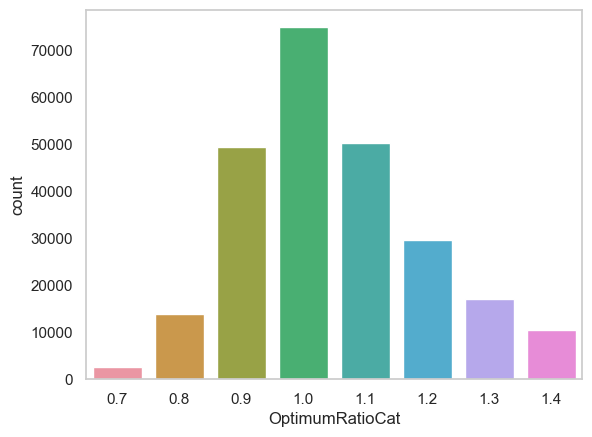

In [72]:
# bar chart of the OptimumRatioCat
sns.countplot(data=sn_full, x='OptimumRatioCat')
sns.set_style('whitegrid')
plt.grid(False)
plt.show()

# print result in percentage with 2 decimals

# for i in [0.5,0.75,1,1.5,2]:
#     print(f'{i}: {100*sn_full[sn_full["OptimumRatio"] <= i].shape[0]/sn_full.shape[0]:.2f}%')

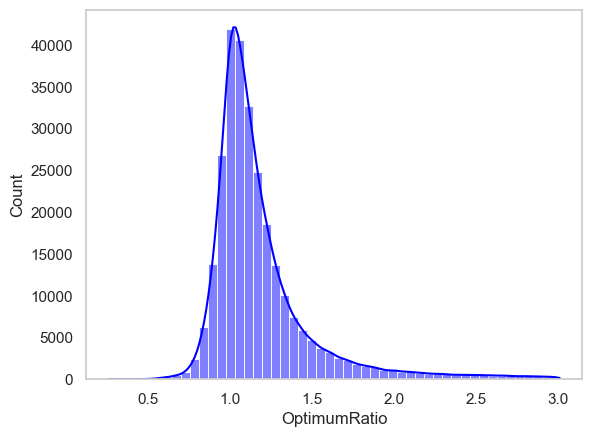

In [88]:
# sn_full[sn_full['OptimumRatio'].between(0.7,1)]['StartHour'].value_counts()/sn_full['StartHour'].value_counts()*100

# sn_full.groupby('StartHour').agg({'OptimumRatio': ['mean', 'median']})
# histogram of OptimumRatio
sns.histplot(data=sn_full[sn_full['OptimumRatio']<3.01], x="OptimumRatio", bins=50, color='blue', kde=True)
# change color of histogram
sns.set_palette('Blues_r')
sns.set_style('whitegrid')
plt.grid(False)
plt.show()

In [261]:
sn_full[np.log10(sn_full['OptimumRatio'])>=3][['StartHour','KmDriven','HaversineDistance','CarDistanceKm','OptimumRatio','DrivenStraightRatio','TripDurationMinutes','CarDurationMin']].sort_values(by='OptimumRatio',ascending=False)

,StartHour,KmDriven,HaversineDistance,CarDistanceKm,OptimumRatio,DrivenStraightRatio,TripDurationMinutes,CarDurationMin
105130,14,36,0.000231,0.00000,inf,155786.292681,107.0,0.016667
131512,22,20,0.000926,0.00000,inf,21587.570560,36.0,0.016667
212585,19,30,0.000737,0.00001,3.000000e+06,40685.336909,75.0,0.016667
171080,15,28,0.000679,0.00001,2.800000e+06,41235.121910,62.0,0.016667
221862,21,36,0.002098,0.00002,1.800000e+06,17162.747544,567.0,0.016667
...,...,...,...,...,...,...,...,...
149086,12,11,0.010927,0.01096,1.003650e+03,1006.689968,33.0,0.016667
110564,14,18,0.019866,0.01794,1.003344e+03,906.089719,36.0,0.233333
12726,9,23,0.024561,0.02296,1.001742e+03,936.448502,185.0,0.183333
108856,0,34,0.034630,0.03398,1.000589e+03,981.796818,55.0,0.066667


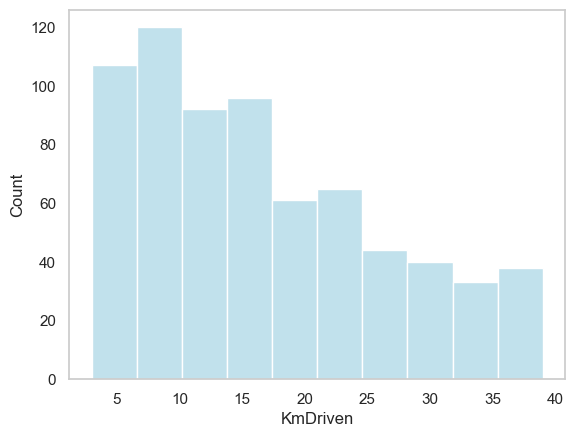

In [137]:
# plot the histogram of the log10 of optimum ratio
test = sn_full[np.log10(sn_full['OptimumRatio'])>=4]
sns.histplot(data=test, x=test['KmDriven'], bins=10, color='lightblue', kde=False)
# change color of histogram
sns.set_palette('Blues_r')
sns.set_style('whitegrid')
plt.grid(False)
plt.show()

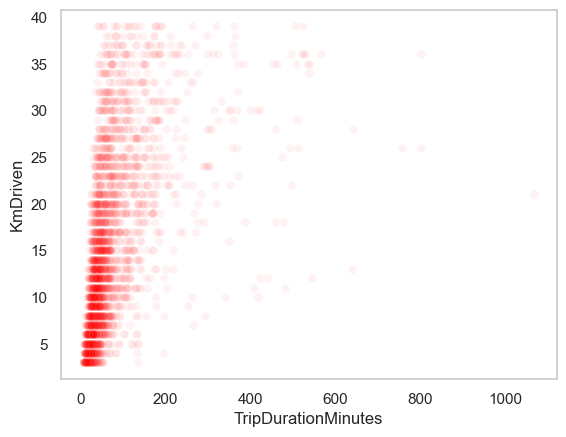

In [135]:

# scatter plot of kmdriven vs tripdurationminutes
sns.scatterplot(data=test, x="TripDurationMinutes", y="KmDriven", alpha=0.05,color='red')
# change color of histogram
sns.set_palette('Blues_r')
sns.set_style('whitegrid')
plt.grid(False)
plt.show()

### Experiment with trip duration

In [185]:
longtime = sn_full[sn_full['TripDurationMinutes']>60]
shorttime = sn_full[sn_full['TripDurationMinutes']<=25]

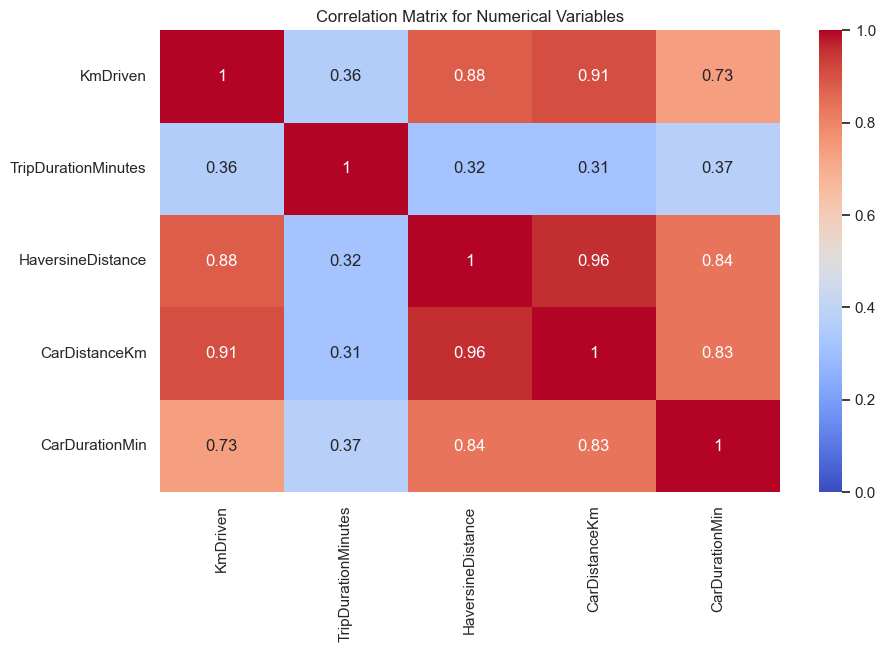

In [186]:
correlation_matrix = shorttime[['KmDriven', 'TripDurationMinutes', 'HaversineDistance','CarDistanceKm','CarDurationMin']].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=0, vmax=1)
plt.title('Correlation Matrix for Numerical Variables')
plt.show()

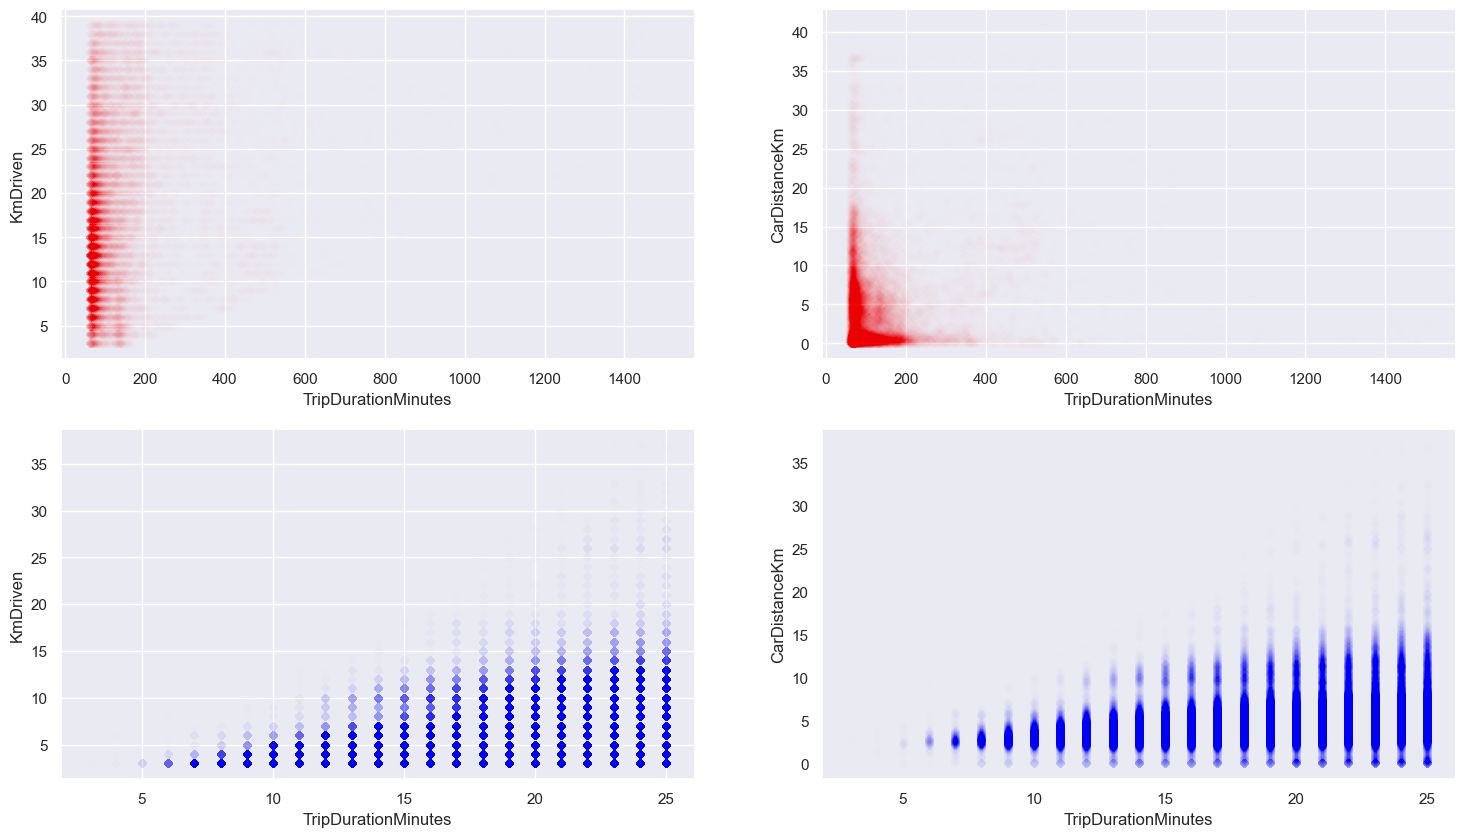

In [214]:
sns.set()

fig, axes = plt.subplots(2,2, figsize = (18,10))
sns.scatterplot(ax = axes[0][0],data=longtime,x='TripDurationMinutes',y='KmDriven',alpha=0.005,color='red')
sns.scatterplot(ax = axes[0][1],data=longtime,x='TripDurationMinutes',y='CarDistanceKm',alpha=0.005,color='red')
sns.scatterplot(ax = axes[1][0],data=shorttime,x='TripDurationMinutes',y='KmDriven',alpha=0.005,color='blue')
sns.scatterplot(ax = axes[1][1],data=shorttime,x='TripDurationMinutes',y='CarDistanceKm',alpha=0.003,color='blue')
sns.set_style('whitegrid')
plt.grid(False)
plt.show()

In [195]:
sn_full[sn_full['TripDurationMinutes']<61][['TripDurationMinutes','CarDistanceKm','HaversineDistance','KmDriven','AvgSpeed','CarDurationMin']].sort_values(by=['TripDurationMinutes','AvgSpeed'], ascending=[False, False])

,TripDurationMinutes,CarDistanceKm,HaversineDistance,KmDriven,AvgSpeed,CarDurationMin
17637,60.0,0.32975,0.309431,39,39.0,2.783333
77113,60.0,0.05577,0.006758,39,39.0,0.150000
210547,60.0,21.89958,17.536169,39,39.0,25.016667
212996,60.0,0.08494,0.040254,39,39.0,0.616667
255794,60.0,16.32893,12.548364,39,39.0,24.116667
...,...,...,...,...,...,...
171510,4.0,3.72628,2.908810,4,60.0,6.216667
171325,4.0,1.60940,1.048350,3,45.0,3.450000
207157,4.0,2.71126,2.338229,3,45.0,4.450000
278339,4.0,3.24375,2.813439,3,45.0,5.866667


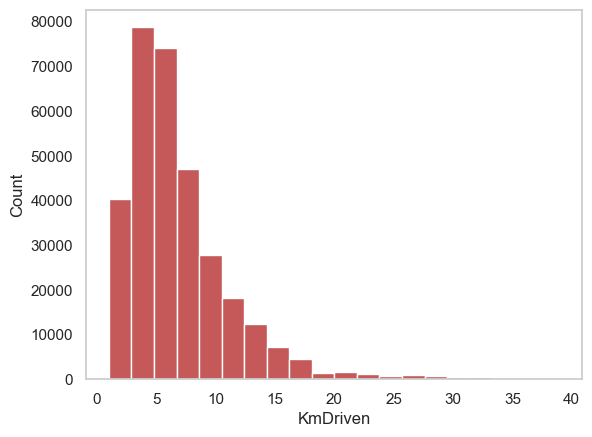

In [260]:
# get 95% percentile of TripDurationMinutes

sn_source['TripDurationMinutes'].quantile(0.96)

mytest = sn_source[(sn_source['TripDurationMinutes']<sn_source['TripDurationMinutes'].quantile(0.90))&(sn_source['KmDriven']<40)]

# plot the histogram of TripDurationMinutes
sns.histplot(data=mytest, x="KmDriven", bins=20, color='firebrick', kde=False)
# change color of histogram
sns.set_palette('Blues_r')
sns.set_style('whitegrid')
plt.grid(False)
plt.show()